In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList_V2_cont1R200.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]

In [5]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [6]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []

    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    Idlist = np.unique(Idlist) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200 
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_near]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_near]
    
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]

    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2+ velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    #and now separate by status.
    # the code: 0, completely free, 1 ICM, 2 in the central, 3 in other galaxy of the cluster, 4 in other galaxy or group.
    Status = np.zeros(IndexT_near.size)
    
    Thegroup = sim['SnapNumber_128/SubGroups/GroupNumber'][fofID]
    gro = sim['SnapNumber_128/SubGroups/GroupNumber'][centralID]
    
    PartGroup = sim['SnapNumber_128/PartType0/GroupNumber'][IndexT_near]
    PartSubGroup = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     free = np.where((PartGroup == -1) & (PartSubGroup ==-1))
#     ICM = np.where((PartGroup == Thegroup) & (PartSubGroup ==-1))
#     centralGal = np.where(PartSubGroup == 0)
#     otherGal = np.where((PartGroup == Thegroup) & (PartSubGroup > 0))
#     otherGroup = np.where((PartGroup != Thegroup) & (PartGroup != -1))
    
    free_other = np.where(PartGroup != Thegroup) # is not in the group
    centralGal = np.where(PartSubGroup == 0)
    otherGal = np.where((PartGroup == Thegroup) & (PartSubGroup > 0))
    ICM = np.where((PartGroup == Thegroup) & (PartSubGroup ==-1))
    
    xRv_free = xRv[free_other]
    yRv_free = yRv[free_other]
    zRv_free = zRv[free_other]
    xRc_free = xRc[free_other]
    yRc_free = yRc[free_other]
    zRc_free = zRc[free_other]
    GasMasses_free = GasMasses[free_other]
    
    xRv_central = xRv[centralGal]
    yRv_central = yRv[centralGal]
    zRv_central = zRv[centralGal]
    xRc_central = xRc[centralGal]
    yRc_central = yRc[centralGal]
    zRc_central = zRc[centralGal]
    GasMasses_central = GasMasses[centralGal]
    
    xRv_ICM = xRv[ICM]
    yRv_ICM = yRv[ICM]
    zRv_ICM = zRv[ICM]
    xRc_ICM = xRc[ICM]
    yRc_ICM = yRc[ICM]
    zRc_ICM = zRc[ICM]
    GasMasses_ICM = GasMasses[ICM]
    
    xRv_other = xRv[otherGal]
    yRv_other = yRv[otherGal]
    zRv_other = zRv[otherGal]
    xRc_other = xRc[otherGal]
    yRc_other = yRc[otherGal]
    zRc_other = zRc[otherGal]
    GasMasses_other = GasMasses[otherGal]
    
    # and return the 2 sets of rotated positions, masses and abundances
    return xRv_free, yRv_free, zRv_free, xRc_free, yRc_free, zRc_free, GasMasses_free, xRv_central \
    , yRv_central, zRv_central, xRc_central, yRc_central, zRc_central, GasMasses_central \
    , xRv_ICM, yRv_ICM, zRv_ICM, xRc_ICM, yRc_ICM, zRc_ICM, GasMasses_ICM \
    , xRv_other, yRv_other, zRv_other, xRc_other, yRc_other, zRc_other, GasMasses_other

In [7]:
# ok, lets try if this works before apply some serialized use.

xRv_free, yRv_free, zRv_free, xRc_free, yRc_free, zRc_free, GasMasses_free, xRv_central \
    , yRv_central, zRv_central, xRc_central, yRc_central, zRc_central, GasMasses_central \
    , xRv_ICM, yRv_ICM, zRv_ICM, xRc_ICM, yRc_ICM, zRc_ICM, GasMasses_ICM \
    , xRv_other, yRv_other, zRv_other, xRc_other, yRc_other, zRc_other, GasMasses_other = getAllLastP(4470, 4469)
print(xRv_free.size, xRv_central.size, xRv_ICM.size, xRv_other.size)

4461 3008 2122 183


Text(0, 0.5, 'z/(ckpc h^{-1})')

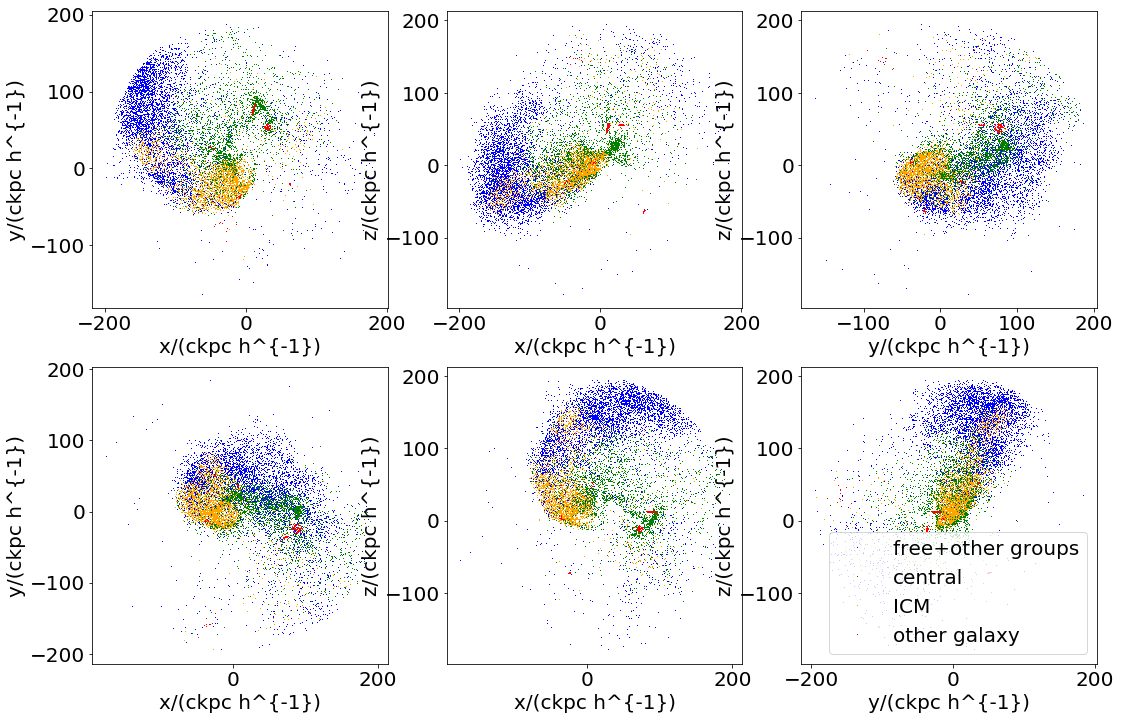

In [8]:
mark = ','
pl.figure(figsize=(18, 12))

pl.subplot(2, 3, 1)

pl.plot(xRv_free, yRv_free, marker=mark, ls='', color='blue', label='free+other groups')
pl.plot(xRv_central, yRv_central, marker=mark, ls='', color='green', label='central')
pl.plot(xRv_ICM, yRv_ICM, marker=mark, ls='', color='orange', label='ICM')
pl.plot(xRv_other, yRv_other, marker=mark, ls='', color='red', label='other galaxy')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')
#pl.arrow(0, 0, newV[0], newV[1], color='black', width=5)

pl.subplot(2, 3, 2)

pl.plot(xRv_free, zRv_free, marker=mark, ls='', color='blue', label='free+other groups')
pl.plot(xRv_central, zRv_central, marker=mark, ls='', color='green', label='central')
pl.plot(xRv_ICM, zRv_ICM, marker=mark, ls='', color='orange', label='ICM')
pl.plot(xRv_other, zRv_other, marker=mark, ls='', color='red', label='other galaxy')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newV[0], newV[2], color='black', width=5)

pl.subplot(2, 3, 3)

pl.plot(yRv_free, zRv_free, marker=mark, ls='', color='blue', label='free+other groups')
pl.plot(yRv_central, zRv_central, marker=mark, ls='', color='green', label='central')
pl.plot(yRv_ICM, zRv_ICM, marker=mark, ls='', color='orange', label='ICM')
pl.plot(yRv_other, zRv_other, marker=mark, ls='', color='red', label='other galaxy')
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newV[1], newV[2], color='black', width=5)

pl.subplot(2, 3, 4)

pl.plot(xRc_free, yRc_free, marker=mark, ls='', color='blue', label='free+other groups')
pl.plot(xRc_central, yRc_central, marker=mark, ls='', color='green', label='central')
pl.plot(xRc_ICM, yRc_ICM, marker=mark, ls='', color='orange', label='ICM')
pl.plot(xRc_other, yRc_other, marker=mark, ls='', color='red', label='other galaxy')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')
#pl.arrow(0, 0, newC[0], newC[1], color='black', width=5)

pl.subplot(2, 3, 5)

pl.plot(xRc_free, zRc_free, marker=mark, ls='', color='blue', label='free+other groups')
pl.plot(xRc_central, zRc_central, marker=mark, ls='', color='green', label='central')
pl.plot(xRc_ICM, zRc_ICM, marker=mark, ls='', color='orange', label='ICM')
pl.plot(xRc_other, zRc_other, marker=mark, ls='', color='red', label='other galaxy')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newC[0], newC[2], color='black', width=5)

pl.subplot(2, 3, 6)

pl.plot(yRc_free, zRc_free, marker=mark, ls='', color='blue', label='free+other groups')
pl.plot(yRc_central, zRc_central, marker=mark, ls='', color='green', label='central')
pl.plot(yRc_ICM, zRc_ICM, marker=mark, ls='', color='orange', label='ICM')
pl.plot(yRc_other, zRc_other, marker=mark, ls='', color='red', label='other galaxy')

pl.legend(loc='best')

pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newC[1], newC[2], color='black', width=5)

In [9]:
# and it works, lets take a look at all at the same time
import progressbar

In [10]:
size = Satellites.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv_free, YRv_free, ZRv_free, XRc_free, YRc_free, ZRc_free, GASMasses_free = [], [], [], [], [], [], []
XRv_central, YRv_central, ZRv_central, XRc_central, YRc_central, ZRc_central, GASMasses_central = [], [], [], [], [], [], []
XRv_ICM, YRv_ICM, ZRv_ICM, XRc_ICM, YRc_ICM, ZRc_ICM, GASMasses_ICM = [], [], [], [], [], [], []
XRv_other, YRv_other, ZRv_other, XRc_other, YRc_other, ZRc_other, GASMasses_other = [], [], [], [], [], [], []

for ff, cc in zip(Satellites, Centrals):
    try:
        xRv_free, yRv_free, zRv_free, xRc_free, yRc_free, zRc_free, GasMasses_free, xRv_central \
    , yRv_central, zRv_central, xRc_central, yRc_central, zRc_central, GasMasses_central \
    , xRv_ICM, yRv_ICM, zRv_ICM, xRc_ICM, yRc_ICM, zRc_ICM, GasMasses_ICM \
    , xRv_other, yRv_other, zRv_other, xRc_other, yRc_other, zRc_other, GasMasses_other = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv_free.extend(list(xRv_free))
    YRv_free.extend(list(yRv_free))
    ZRv_free.extend(list(zRv_free))
    XRc_free.extend(list(xRc_free))
    YRc_free.extend(list(yRc_free))
    ZRc_free.extend(list(zRc_free))
    GASMasses_free.extend(list(GasMasses_free))
    
    XRv_central.extend(list(xRv_central))
    YRv_central.extend(list(yRv_central))
    ZRv_central.extend(list(zRv_central))
    XRc_central.extend(list(xRc_central))
    YRc_central.extend(list(yRc_central))
    ZRc_central.extend(list(zRc_central))
    GASMasses_central.extend(list(GasMasses_central))
    
    XRv_ICM.extend(list(xRv_ICM))
    YRv_ICM.extend(list(yRv_ICM))
    ZRv_ICM.extend(list(zRv_ICM))
    XRc_ICM.extend(list(xRc_ICM))
    YRc_ICM.extend(list(yRc_ICM))
    ZRc_ICM.extend(list(zRc_ICM))
    GASMasses_ICM.extend(list(GasMasses_ICM))
    
    XRv_other.extend(list(xRv_other))
    YRv_other.extend(list(yRv_other))
    ZRv_other.extend(list(zRv_other))
    XRc_other.extend(list(xRc_other))
    YRc_other.extend(list(yRc_other))
    ZRc_other.extend(list(zRc_other))
    GASMasses_other.extend(list(GasMasses_other))
    
    C += 1
    bar.update(C)
    
XRv_free, YRv_free, ZRv_free = np.array(XRv_free), np.array(YRv_free), np.array(ZRv_free)
XRc_free, YRc_free, ZRc_free, GASMasses_free = np.array(XRc_free), np.array(YRc_free), np.array(ZRc_free), np.array(GASMasses_free)
XRv_central, YRv_central, ZRv_central = np.array(XRv_central), np.array(YRv_central), np.array(ZRv_central)
XRc_central, YRc_central, ZRc_central, GASMasses_central = np.array(XRc_central), np.array(YRc_central), np.array(ZRc_central), np.array(GASMasses_central)
XRv_ICM, YRv_ICM, ZRv_ICM = np.array(XRv_ICM), np.array(YRv_ICM), np.array(ZRv_ICM)
XRc_ICM, YRc_ICM, ZRc_ICM, GASMasses_ICM = np.array(XRc_ICM), np.array(YRc_ICM), np.array(ZRc_ICM), np.array(GASMasses_ICM)
XRv_other, YRv_other, ZRv_other = np.array(XRv_other), np.array(YRv_other), np.array(ZRv_other)
XRc_other, YRc_other, ZRc_other, GASMasses_other = np.array(XRc_other), np.array(YRc_other), np.array(ZRc_other), np.array(GASMasses_other)

 98% (509 of 515) |##################### | Elapsed Time: 0:18:45 ETA:   0:00:00

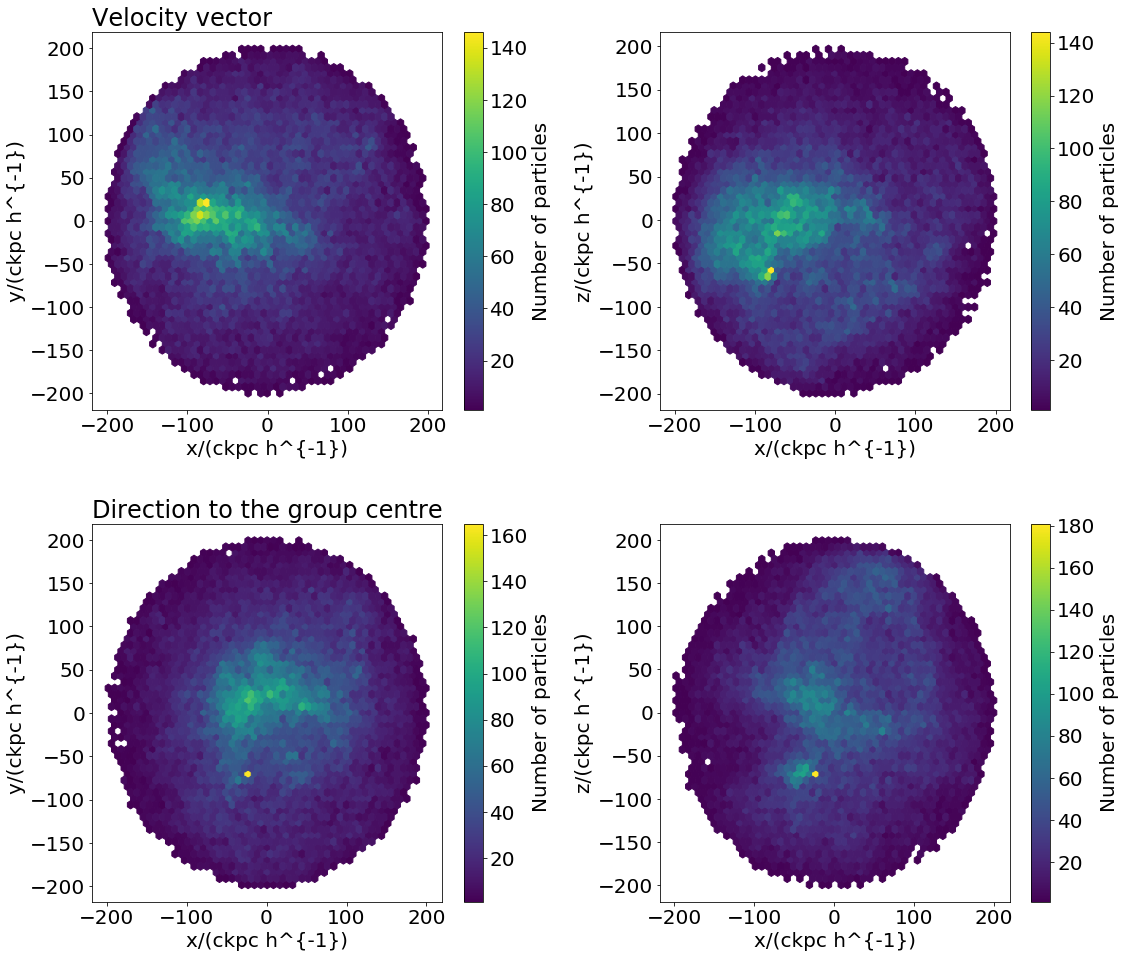

In [11]:
# frees
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_free, YRv_free, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_free, ZRv_free, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_free, YRc_free, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_free, ZRc_free, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

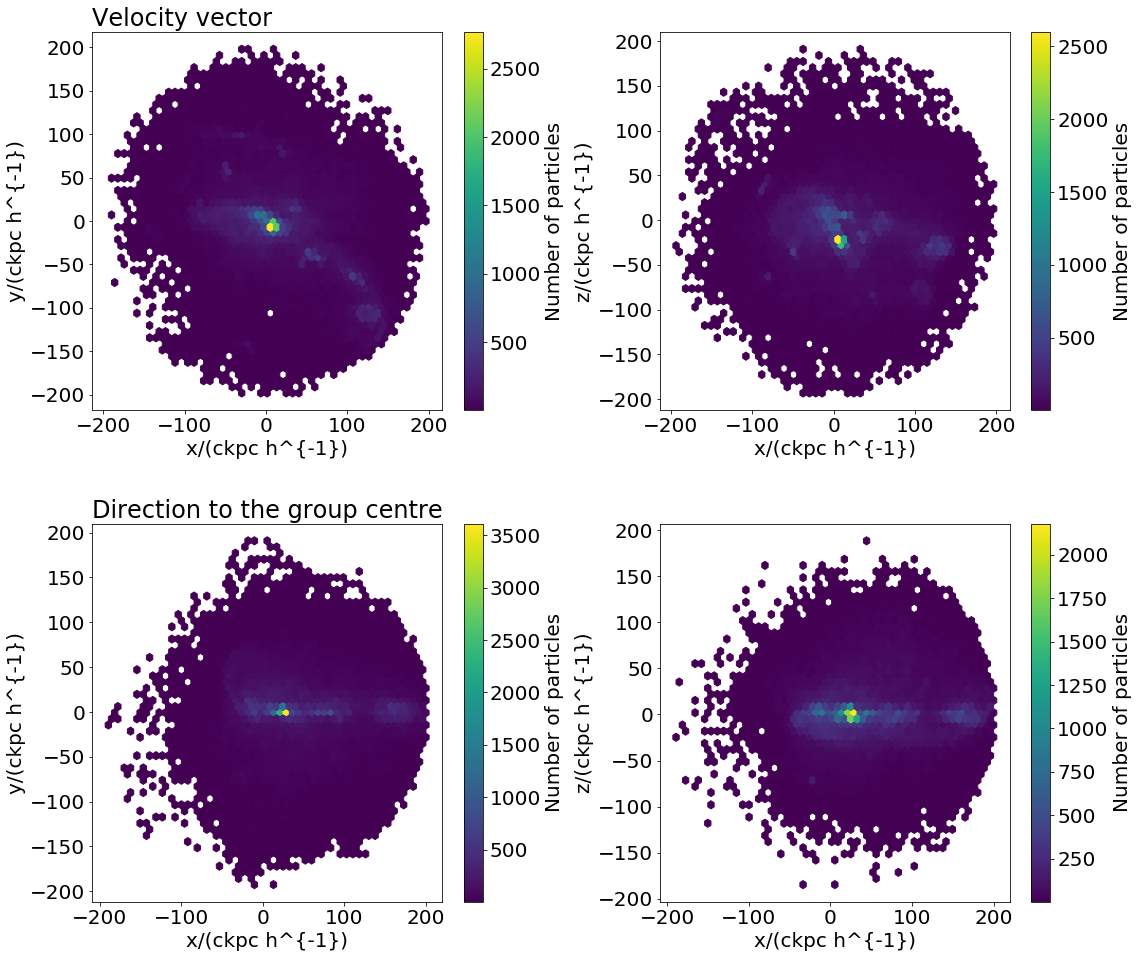

In [12]:
# centrals
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_central, YRv_central, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_central, ZRv_central, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_central, YRc_central, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_central, ZRc_central, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

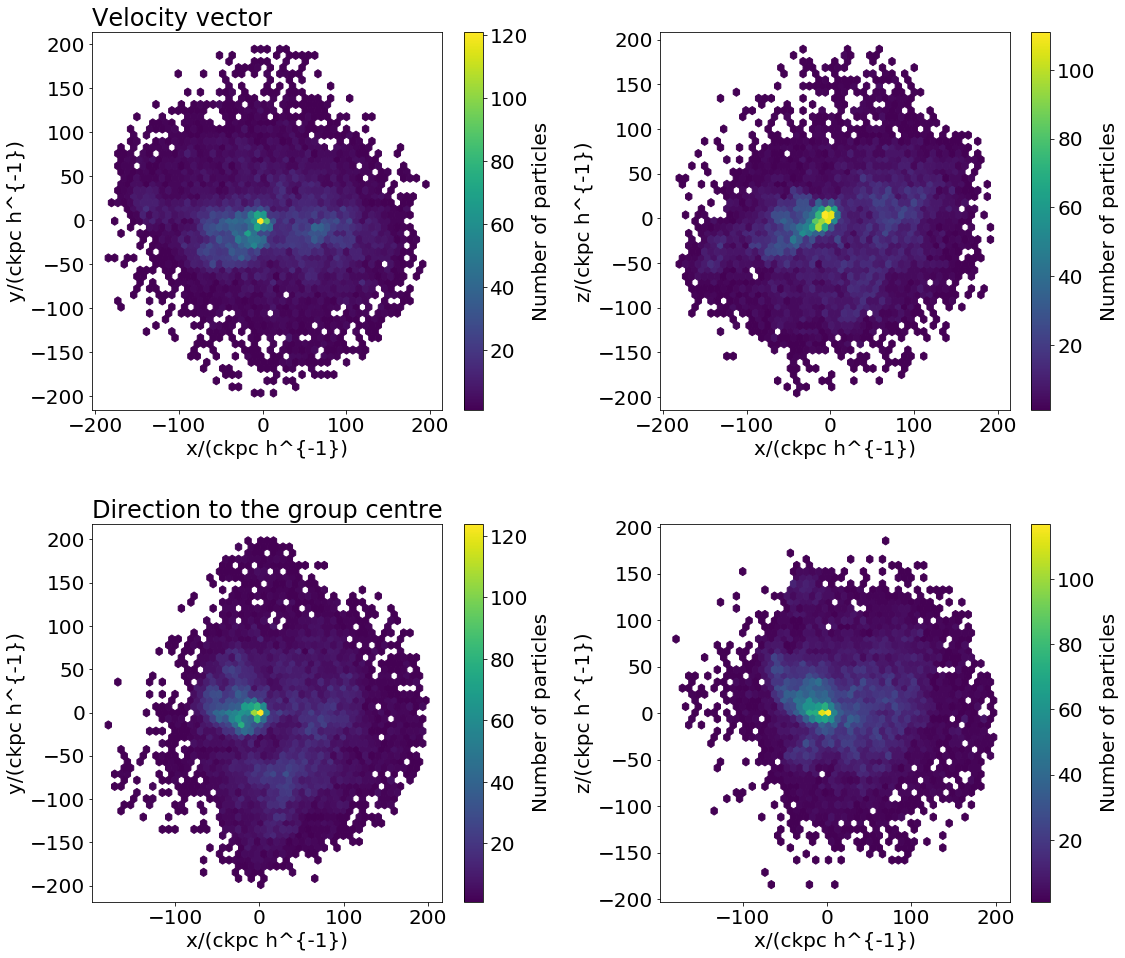

In [13]:
# ICMs
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_ICM, YRv_ICM, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_ICM, ZRv_ICM, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_ICM, YRc_ICM, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_ICM, ZRc_ICM, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

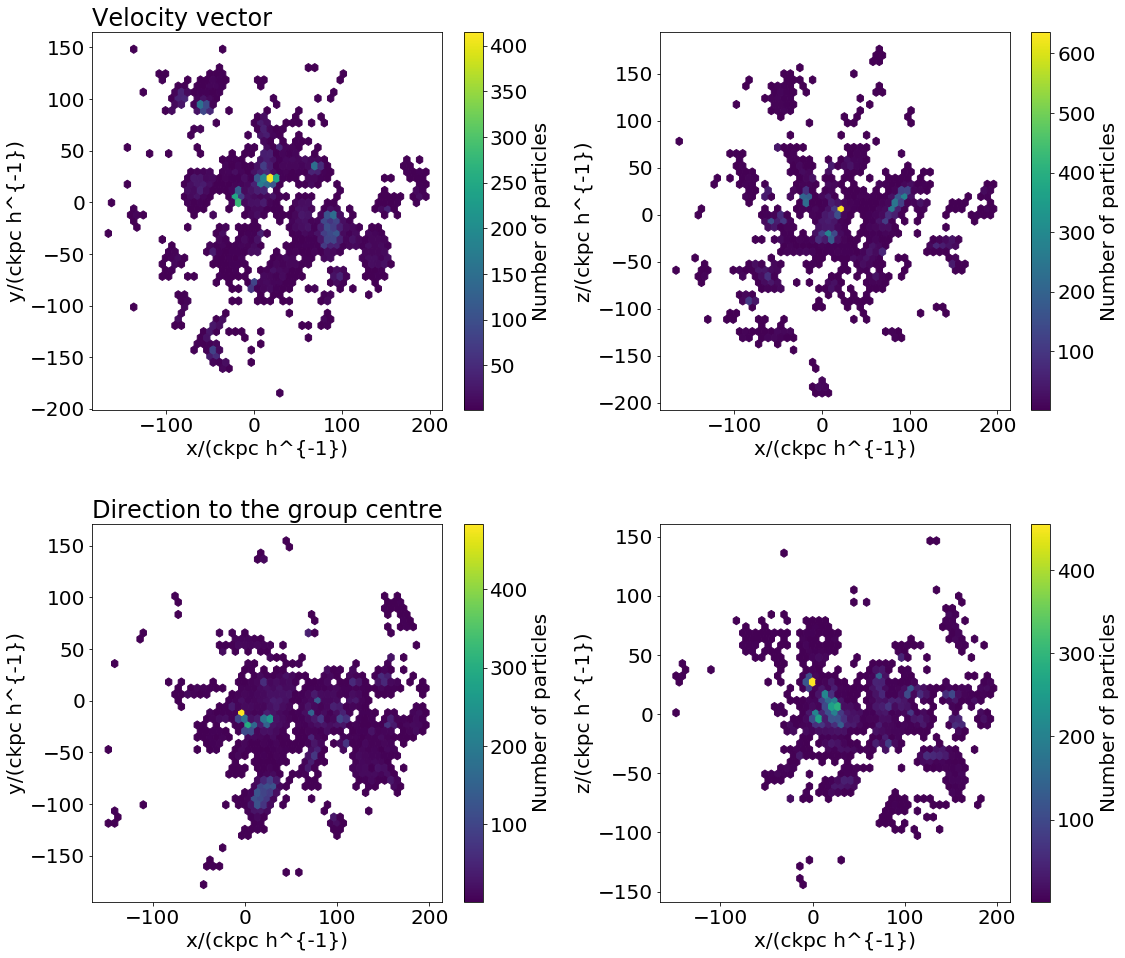

In [14]:
# others
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_other, YRv_other, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_other, ZRv_other, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_other, YRc_other, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_other, ZRc_other, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

In [15]:
sim['SnapNumber_127/PartType0/Abundances'].attrs['description']

'Mass in individual elements: He, C, Mg, O, Fe, Si, H, N, Ne, S, Ca, Zi (in this order)'

In [16]:
GASAbundances.shape

NameError: name 'GASAbundances' is not defined

In [ ]:
Si = GASAbundances[:,5]

pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.5, hspace=0.3)
binn = 'log'

pl.subplot(2, 2, 1)

pl.title('Velocity vector', loc='left')

pl.hexbin(XRv, YRv, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/M_sun')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc, YRc, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')